Import Libraies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
import os

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

Load the Dataset

In [3]:
url = '/content/Student Data.csv'

if os.path.exists(url):
    df = pd.read_csv(url)
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
else:
    print(f"File not found at: {url}")

Dataset loaded successfully!
Dataset shape: (4424, 37)

First 5 rows of the dataset:
   Marital_Status_Code  Application_Method  Application_Sequence  Program_ID  \
0                    1                  17                     5         171   
1                    1                  15                     1        9254   
2                    1                   1                     5        9070   
3                    1                  17                     2        9773   
4                    2                  39                     1        8014   

   Attendance_Type  Prior_Qualification_Code  Prior_Qualification_Score  \
0                1                         1                      122.0   
1                1                         1                      160.0   
2                1                         1                      122.0   
3                1                         1                      122.0   
4                0                         1               

EDA Run

In [4]:
print("Basic Dataset Information:")
df.info()

print("\nStatistical Summary of Numerical Features:")
print(df.describe())

print("\nChecking for Duplicate Rows:")
print(f"Number of duplicate rows: {df.duplicated().sum()}")

df.drop_duplicates(inplace=True)
print(f"Dataset shape after dropping duplicates: {df.shape}")


Basic Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Marital_Status_Code          4424 non-null   int64  
 1   Application_Method           4424 non-null   int64  
 2   Application_Sequence         4424 non-null   int64  
 3   Program_ID                   4424 non-null   int64  
 4   Attendance_Type              4424 non-null   int64  
 5   Prior_Qualification_Code     4424 non-null   int64  
 6   Prior_Qualification_Score    4424 non-null   float64
 7   Nationality_Code             4424 non-null   int64  
 8   Mother's_Education_Level     4424 non-null   int64  
 9   Father's_Education_Level     4424 non-null   int64  
 10  Mother's_Job_Category        4424 non-null   int64  
 11  Father's_Job_Category        4424 non-null   int64  
 12  Admission_Score              4424 non-null   floa

Handling Missing Values

In [5]:
print("Missing Values Check:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("\nNo missing values found in the dataset ")


Missing Values Check:
Series([], dtype: int64)

No missing values found in the dataset 


Outlier Detection

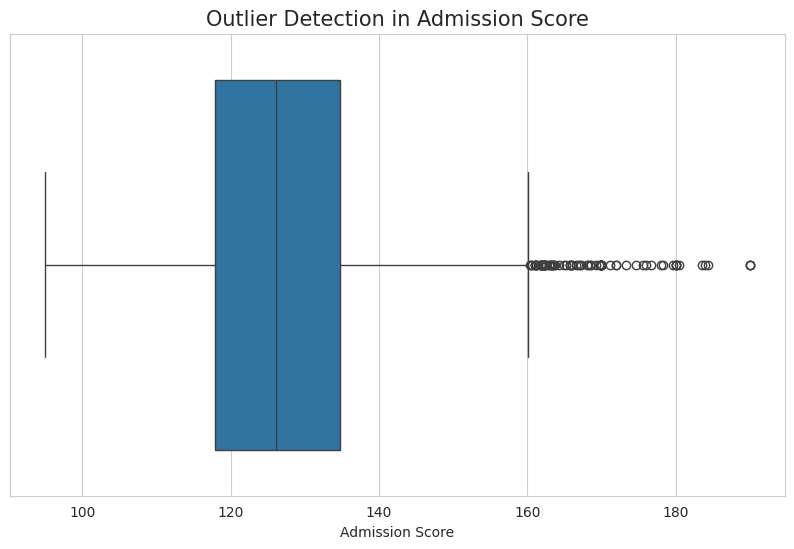

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Admission_Score'])
plt.title('Outlier Detection in Admission Score', fontsize=15)
plt.xlabel('Admission Score')
plt.show()


Categorical Encoding

In [7]:
# Encode the target variable 'Outcome' into numerical values
le = LabelEncoder()
df['Outcome_encoded'] = le.fit_transform(df['Outcome'])

print("Target Variable Encoding:")
print("Original categories:", le.classes_)
print("Encoded values:", le.transform(le.classes_))


Target Variable Encoding:
Original categories: ['Dropout' 'Enrolled' 'Graduate']
Encoded values: [0 1 2]


Data Visualization

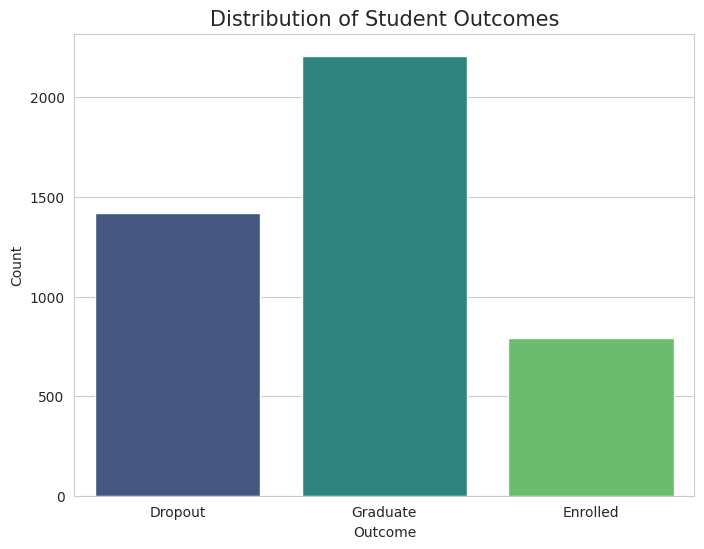

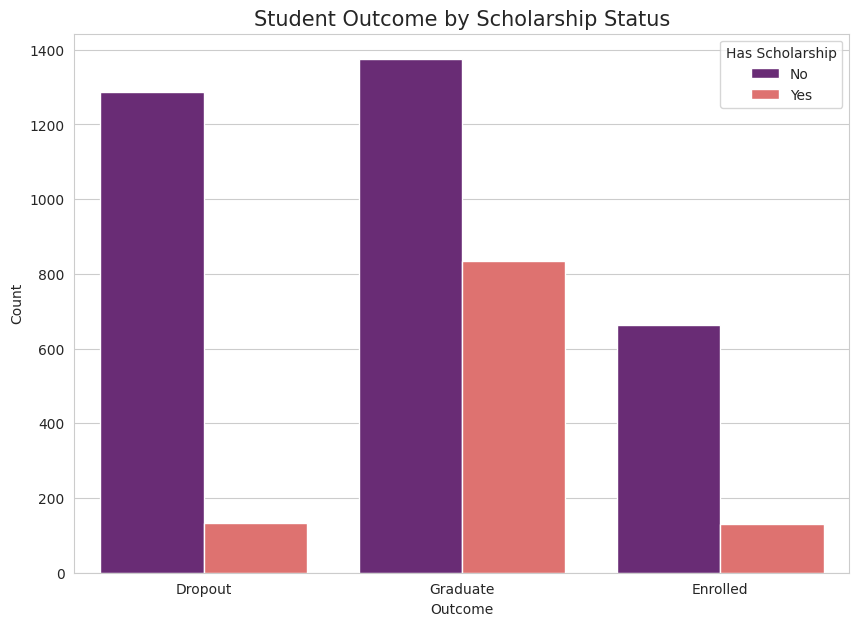

In [8]:
# Plot distribution of student outcomes
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df, palette='viridis')
plt.title('Distribution of Student Outcomes', fontsize=15)
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

# Plot outcome distribution by scholarship status
plt.figure(figsize=(10, 7))
sns.countplot(x='Outcome', hue='Scholarship_Recipient_Flag', data=df, palette='magma')
plt.title('Student Outcome by Scholarship Status', fontsize=15)
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.legend(title='Has Scholarship', labels=['No', 'Yes'])
plt.show()


Correlation Heatmap

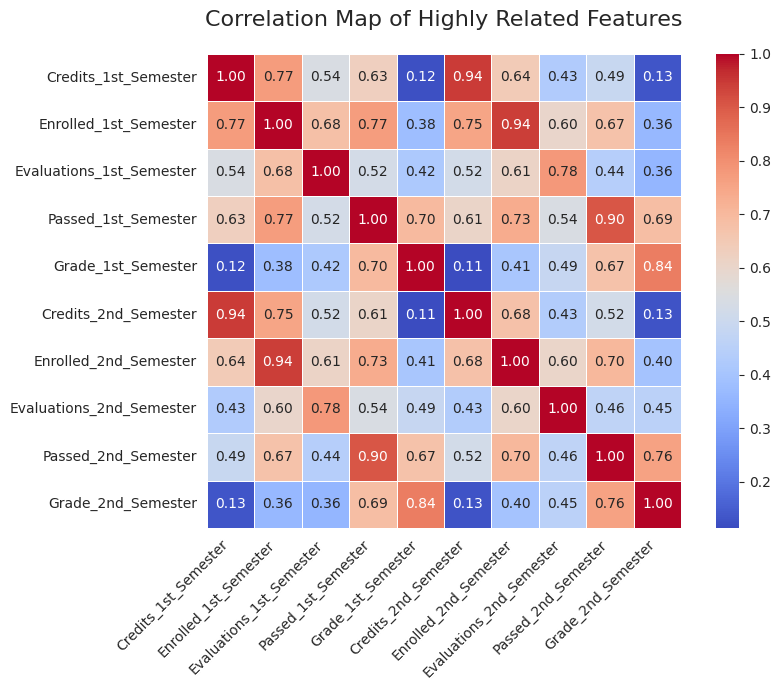

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select only the top correlated features
top_corr_features = [
    'Credits_1st_Semester',
    'Enrolled_1st_Semester',
    'Evaluations_1st_Semester',
    'Passed_1st_Semester',
    'Grade_1st_Semester',
    'Credits_2nd_Semester',
    'Enrolled_2nd_Semester',
    'Evaluations_2nd_Semester',
    'Passed_2nd_Semester',
    'Grade_2nd_Semester'
]

# Extract correlation matrix for those features only
corr_matrix = df[top_corr_features].corr()

# Plot clean and complete heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)
plt.title('Correlation Map of Highly Related Features', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Feature Engineering

In [ ]:
# Create new feature: pass rate for 1st semester
df['pass_rate_1st_sem'] = df['Passed_1st_Semester'] / (df['Enrolled_1st_Semester'] + 1e-6)

# Create new feature: grade difference between semesters
df['grade_diff_semesters'] = df['Grade_2nd_Semester'] - df['Grade_1st_Semester']

# Display sample of new features
print("Created New Features:")
print(df[['pass_rate_1st_sem', 'grade_diff_semesters']].head())


Created New Features:
   pass_rate_1st_sem  grade_diff_semesters
0           0.000000              0.000000
1           1.000000             -0.333333
2           0.000000              0.000000
3           1.000000             -1.028571
4           0.833333              0.666667


Model Building & Hyperparameter Tuning

In [ ]:
# Split features and target
X = df.drop(['Outcome', 'Outcome_encoded'], axis=1)
y = df['Outcome_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define machine learning models
models = {
    'Logistic Regression': LogisticRegression(
        C=1, penalty='l2', solver='saga', max_iter=2000, random_state=42
    ),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# Train each model
print("Training Models:")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)

print("\nAll models trained successfully!")

Training Models:
Training Logistic Regression...
Training Random Forest...
Training XGBoost...

All models trained successfully


Model Evaluation

In [ ]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluate each trained model
results = []
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    precision = precision_score(y_test, y_pred, average='macro')  # Calculate precision
    recall = recall_score(y_test, y_pred, average='macro')  # Calculate recall
    f1 = f1_score(y_test, y_pred, average='macro')  # Calculate F1 score
    results.append([name, accuracy, precision, recall, f1])  # Store results

# Create DataFrame of results
results_df = pd.DataFrame(
    results,
    columns=['Model', 'Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-score (Macro)']
)

# Sort models by F1 score
results_df_sorted = results_df.sort_values(by='F1-score (Macro)', ascending=False).reset_index(drop=True)

# Display model comparison table
print("Model Performance Comparison:")
print(results_df_sorted)

# Select and display best model report
best_model_name = results_df_sorted.iloc[0]['Model']  # Get top model name
best_model = models[best_model_name]  # Get model object
print(f"\nDetailed Classification Report for {best_model_name}:")
y_pred_best = best_model.predict(X_test_scaled)  # Predict with best model
print(classification_report(y_test, y_pred_best, target_names=le.classes_))  # Print report


Model Performance Comparison:
                 Model  Accuracy  Precision (Macro)  Recall (Macro)  \
0              XGBoost  0.763842           0.709420        0.689607   
1        Random Forest  0.772881           0.720365        0.682889   
2  Logistic Regression  0.771751           0.710867        0.678528   

   F1-score (Macro)  
0          0.697028  
1          0.691832  
2          0.685744  

Detailed Classification Report for XGBoost:
              precision    recall  f1-score   support

     Dropout       0.81      0.74      0.77       284
    Enrolled       0.51      0.43      0.47       159
    Graduate       0.81      0.90      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.69      0.70       885
weighted avg       0.76      0.76      0.76       885



 Cross-Validation

In [ ]:
# Perform 10-fold cross-validation on the best model
from sklearn.model_selection import cross_val_score

print("Performing 10-fold Cross-Validation on the Final Model:")

cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=10, scoring='accuracy')  # Compute CV scores

# Display cross-validation results
print(f"Cross-Validation Accuracy Scores: {np.round(cv_scores, 4)}")  # Show all scores
print(f"Average CV Accuracy: {cv_scores.mean():.4f}")  # Show mean accuracy
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")  # Show standard deviation


Performing 10-fold Cross-Validation on the Final Model:
Cross-Validation Accuracy Scores: [0.7627 0.7712 0.7571 0.7825 0.7599 0.7853 0.8051 0.7571 0.8023 0.7564]
Average CV Accuracy: 0.7739
Standard Deviation of CV Accuracy: 0.0178


Visualize Results

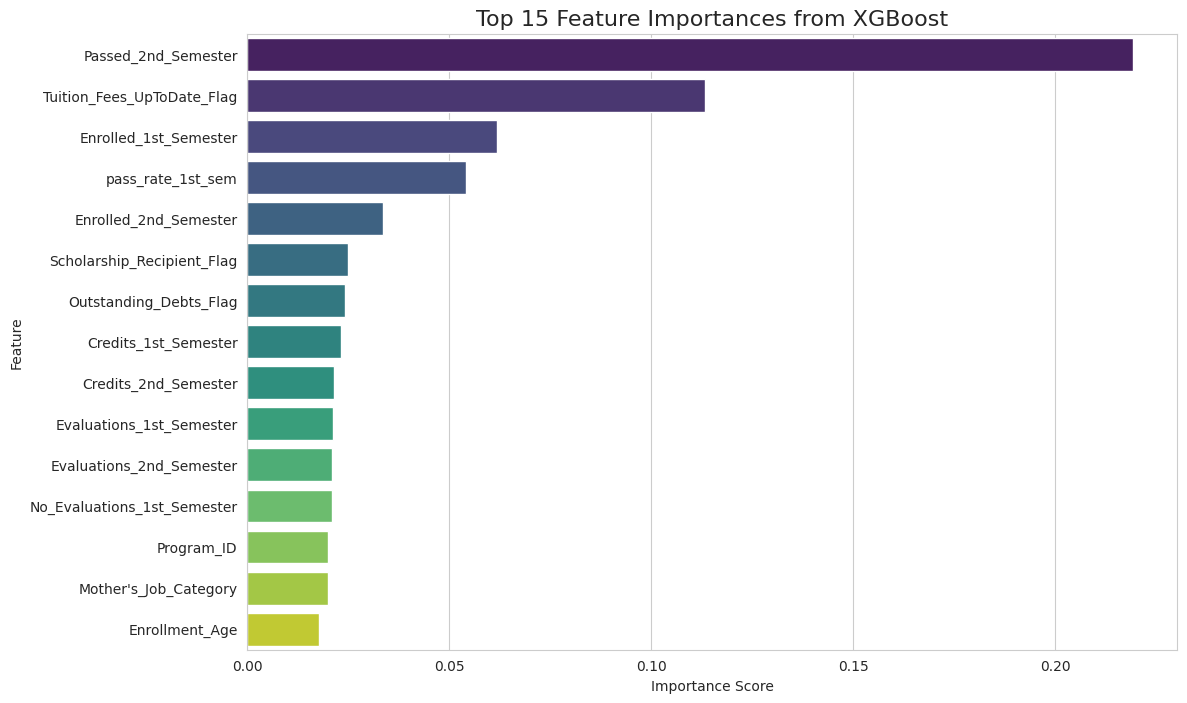

In [ ]:
best_model_name = results_df_sorted.iloc[0]['Model']
best_model = models[best_model_name]

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Top 15 Feature Importances from {best_model_name}', fontsize=16)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
else:
    print(f"The best model ({best_model_name}) does not provide feature importances.")
